In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def atomic_read_in(datfile):
    with open(datfile, 'r') as f:
        for line in f:
            line = line.strip()
            # dim i j R H_ij, space separated
            if line.startswith('#'):
                dim = int(line.split(' ')[1])
                H_ij0 = np.zeros((dim,dim))
                H_ij1 = np.zeros((dim,dim))
                H_ijn1 = np.zeros((dim,dim))
                H_ij = {0: H_ij0, 1: H_ij1, -1: H_ijn1}
            else:
                ele = line.split(' ')
                H_ij[int(ele[2])][int(ele[0]),int(ele[1])] = float(ele[3])
    return H_ij     

In [3]:
def atomic_to_reciprocal(H_ij,k):
    H_k = np.zeros_like(H_ij[0],dtype='complex128') # definitely a key
    for key in H_ij.keys():
        key = int(key)
        H_k+=np.exp(k*key*1j)*H_ij[key]
    return H_k

In [4]:
def berry_discrete(H_ij,k_dens):
    k_points = np.linspace(-np.pi,np.pi,k_dens)
    u0 = np.linalg.eigh(atomic_to_reciprocal(H_ij,k_points[0]))[1][:,0]
    uold = u0
    berry = 0
    for k in k_points[1:]:
        unew = np.linalg.eigh(atomic_to_reciprocal(H_ij,k))[1][:,0]
        berry += -np.imag(np.log(np.vdot(uold,unew)))
        uold = unew
    berry += -np.imag(np.vdot(uold,u0))
    return (berry%(2*np.pi))/np.pi

In [5]:
def plot(k_dens, H_ij):
    k_points = np.linspace(-np.pi,np.pi,k_dens)
    bandstr = []
    for k in k_points:
        bandstr.append(np.linalg.eigvalsh(atomic_to_reciprocal(H_ij,k)))
    bandstr = np.array(bandstr)
    plt.plot(k_points,bandstr[:,0])
    plt.plot(k_points,bandstr[:,1])

In [73]:
H_ij_top = atomic_read_in('ssh_top.dat')
H_ij_trivial = atomic_read_in('ssh_trivial.dat')
H_ij_both1 = atomic_read_in('ssh_both1.dat')

In [70]:
H_ij_trivial

{0: array([[0., 1.],
        [1., 0.]]),
 1: array([[0. , 0. ],
        [0.6, 0. ]]),
 -1: array([[0. , 0.6],
        [0. , 0. ]])}

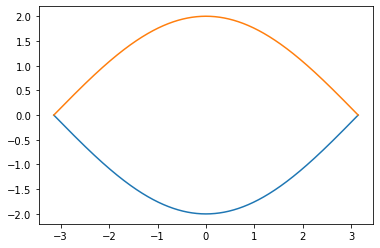

In [74]:
plot(1000, H_ij_both1)

In [95]:
berry_discrete(H_ij_top,1000)

3.1415926535897953

In [96]:
def atom_hamil_iter(v, w):
    h0 = np.array([[0,v],[v,0]])
    h1 = np.array([[0,0],[w,0]])
    hn1 = np.array([[0,w],[0,0]])
    return {0:h0,1:h1,-1:hn1}

In [121]:
size = 20
v_range = np.linspace(0,1,size)
w_range = np.linspace(0,1,size)
berry = np.zeros((size,size))
for iv, v in enumerate(v_range):
    for iw, w in enumerate(w_range):
        hamil = atom_hamil_iter(v,w)
        berry[iv,iw] = berry_discrete(hamil,500)

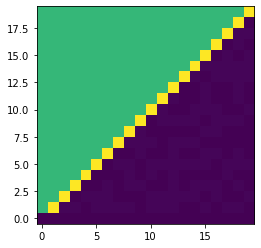

In [132]:
plt.imshow(np.swapaxes(berry_mod2,0,1),origin='lower')
plt.

In [131]:
berry_mod2 = berry%1.98
berry_mod2[0,:]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

To do a supercell calculation to show edge-bulk correspondence, the above code is not really suitable. We just do direct diagonalisation in real space below.

In [35]:
def edge_hamil(v, w, N):
    """
    v: intracell hopping
    w: intercell hopping
    N: number of cells (2 sites, 1 electron each cell)
    """
    offdiag = []
    for i in range(2*N-1):
        if i%2 == 0:
            offdiag.append(v)
        else:
            offdiag.append(w)
    hamil = (np.diag(offdiag,-1) + np.diag(offdiag,1))
    return np.linalg.eigh(hamil)

<BarContainer object of 60 artists>

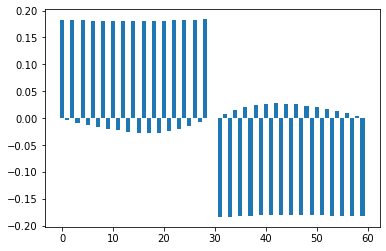

In [65]:
N = 30
edgestate = edge_hamil(0.3,1,N)[1][N-1]
plt.bar(list(range(2*N)),edgestate)